In [6]:
import networkx as nx

El método `erdos_renyi_graph(n,p)` crea un grafo aleatorio del tipo Erdos-Renyi con parámetros `n` y `p`, un tipo especial de grafos  con `n` nodos 

El método `barabasi_albert_graph(n,m)` crea un grafo aleatorio del tipo Barabasi-Albert con `n` nodos. En este modelo se genera el grafo anañdiendo cada nodo secuencialmente y asignádole `m` aristas. La probabilidad de que una de estas aristas una el nuevo nodo con el nodo `i` preexistente viene dada por la expresión:
\begin{equation}
p_i=\frac{k_i}{\sum_jk_j}
\end{equation}
donde $k_i$ se corresponde con el número de aristas del nodo $i$, es decir, su *grado*. Este tipo de grafos es de especial relevancia porque su distribución del grado de sus nodos es del mismo que muchas redes que surgen de forma natural o por fenómenos relacionados con los humanos, por ejemplo, Internet o la red de citaciones de artículos de investigación. Su característica principal es la aparición de nodos con un gran número de conexiones, lo que se puede explicar en base a la probabilidad (1) que favorece que los nodos con grado alto tengan nuevas aristas.

In [7]:
G = nx.barabasi_albert_graph(10, 2,seed=47)

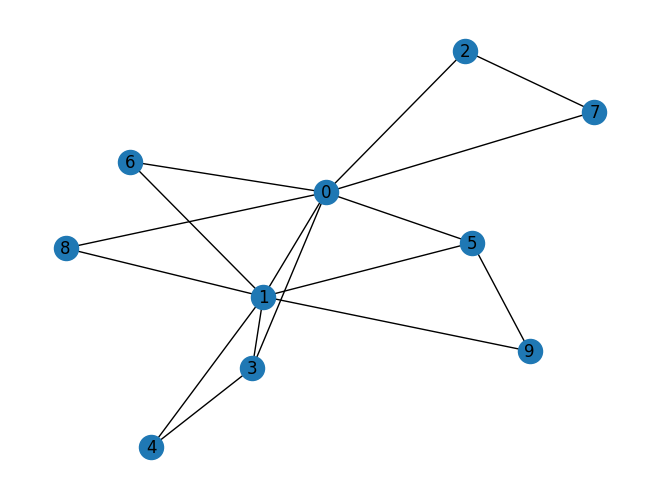

In [9]:
nx.draw(G, with_labels=True)

### Crea la modelo de Ising que implementa el Max Cut problem para un grafo genérico de la librería `networkx`. 

**AYUDA**: Recuerda que con los métodos `nodes` y `edges` puedes obtener iterable con los nodos y las aristas de un objeto `networkx.Graph`.

In [10]:
def max_cut_ising(G):
    h = {} # linear biases
    J = {} # quadratic biases
    ## Introduce aquí tu código
    for i in G.nodes():
        h[i] = 0
        for j in G.neighbors(i):
            J[(i,j)] = 1
    return h, J

### Resuelve el problema en una QPU de DWave 
También puedes usar un solver clásico si quieres ahorrar tiempo de uso en Leap.

In [11]:
# solve the max-cut problem on D-Wave
h, J = max_cut_ising(G)
# from dwave.system import DWaveSampler, EmbeddingComposite
# sampler = EmbeddingComposite(DWaveSampler())

# response = sampler.sample_ising(h, J, num_reads=1000)

# solve with simulated annealing
from dwave.samplers import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler()
response_ising = sampler.sample_ising(h, J)

# print the best solution found
print(response_ising.first.sample)
print(response_ising.first.energy)
print(response_ising.first)

{0: np.int8(1), 1: np.int8(1), 2: np.int8(1), 3: np.int8(-1), 4: np.int8(1), 5: np.int8(-1), 6: np.int8(-1), 7: np.int8(-1), 8: np.int8(-1), 9: np.int8(1)}
-16.0
Sample(sample={0: np.int8(1), 1: np.int8(1), 2: np.int8(1), 3: np.int8(-1), 4: np.int8(1), 5: np.int8(-1), 6: np.int8(-1), 7: np.int8(-1), 8: np.int8(-1), 9: np.int8(1)}, energy=np.float64(-16.0), num_occurrences=np.int64(1))


In [12]:
response_ising.record

rec.array([([ 1,  1,  1, -1,  1, -1, -1, -1, -1,  1], -16., 1)],
          dtype=[('sample', 'i1', (10,)), ('energy', '<f8'), ('num_occurrences', '<i8')])

In [13]:
response_ising.first.sample

{0: np.int8(1),
 1: np.int8(1),
 2: np.int8(1),
 3: np.int8(-1),
 4: np.int8(1),
 5: np.int8(-1),
 6: np.int8(-1),
 7: np.int8(-1),
 8: np.int8(-1),
 9: np.int8(1)}

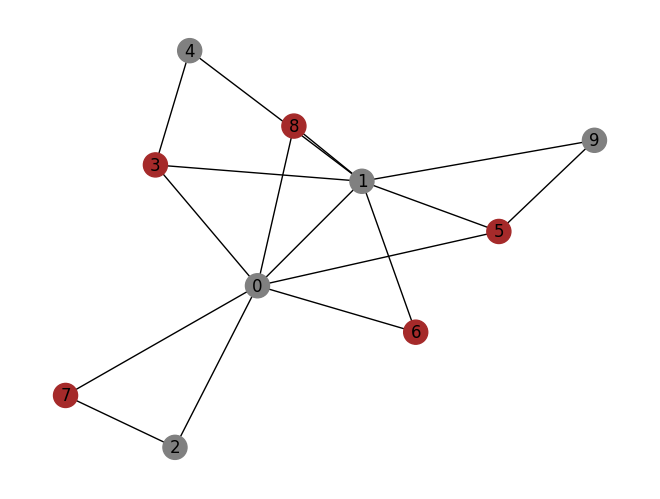

In [14]:
# draw the best solution found
colors = ['brown' if response_ising.first.sample[i] == -1 else 'gray' for i in G.nodes()]
pos = nx.spring_layout(G) # con esto fijamos la posición en el dibujo para que sea más fácil comparar con el resultado de la QUBO
nx.draw(G,pos=pos, with_labels=True, node_color=colors)

### Crea la QUBO que implementa el Max Cut problem para un grafo genérico de la librería `networkx`. 

**AYUDA**: Recuerda que con los métodos `nodes` y `edges` puedes obtener iterable con los nodos y las aristas de un objeto `networkx.Graph`.

Recuerda que la función QUBO para un grafo $G(V,E)$ viene dada por la siguiente expresión:
$$Q(x)=\sum_{(u,v)\in E}(2x_ux_v -x_u -x_v)$$
donde $x_u = 1$ si el nodo $u$ está en la partición $A$ y $x_u = 0$ si está en el complementario (en $\bar{A}=V\backslash A$).

(Es fácil comprobar que la expresión entre paréntesis contribuye al valor total de la QUBO con -2 sólo si $x_u\neq x_v$; en caso contrario, toma el valor cero)

In [15]:
def max_cut_qubo(G):
    qubo = {}
    ## Introduce aquí tu código
    for i,j in G.edges():
        # contribución cuadrática
        qubo[(i,j)] = 2
        
        # contribución lineal
        # si ya está en el diccionario, le sumamos -1
        if (i,i) not in qubo:
            qubo[(i,i)] = -1
        else:
            qubo[(i,i)] -= 1
        if (j,j) not in qubo:
            qubo[(j,j)] = -1
        else:
            qubo[(j,j)] -= 1

    return qubo

In [16]:
import dimod
sampler = dimod.ExactSolver()
qubo = max_cut_qubo(G)
sampleset_qubo = sampler.sample_qubo(qubo)

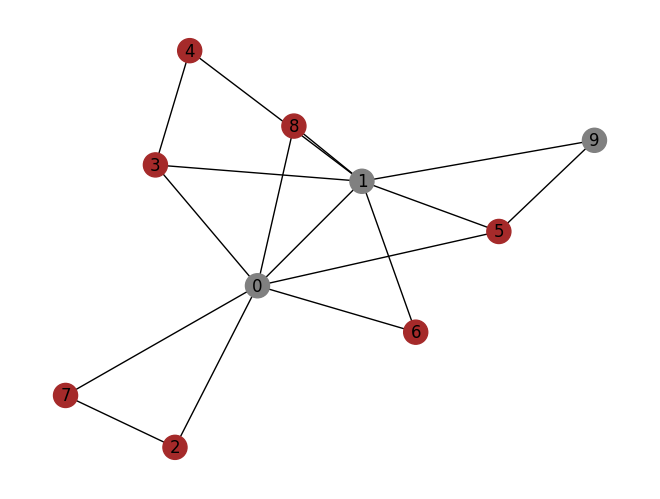

In [17]:
colors = ['brown' if sampleset_qubo.first.sample[i] == 0 else 'gray' for i in G.nodes()]
nx.draw(G,pos, with_labels=True, node_color=colors)

### Comprobación
En las imágenes vemos que las soluciones que obtenemos no son exactamente las mismas, ¿hay algún error?

El problema que estamos resolviendo es el Max Cut y puede haber varias particiones distintas que den lugar al mismo número de cortes. Esa es la situación que está ocurriendo aquí (puedes verificarlo ejecutando las celdas siguientes). 

Cuando programamos es importante tener herramientas adicionales que comprueben la validez de nuestras soluciones. 

In [18]:
cuts_ising = 0
for u,v in G.edges():
    if response_ising.first.sample[u] != response_ising.first.sample[v]:
        cuts_ising += 1
print(cuts_ising)

12


In [19]:
cuts_qubo = 0
for u,v in G.edges():
    if sampleset_qubo.first.sample[u] != sampleset_qubo.first.sample[v]:
        cuts_qubo += 1
print(cuts_qubo)

12
